In [1]:
!pip install plotly

In [2]:
!pip install chainer

     ---------------------------------------- 1.0/1.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967725 sha256=d26aca97e8449bb5e7d2b1d746afc361951ff03f84873ea13d4a4a4fc9231469
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\83\90\84\57741aca5962d73dbeb37ee7a859d3cc31463273a133821071
Successfully built chainer


In [2]:
import time
import copy
import numpy as np
import pandas as pd
import chainer
import chainer.functions as F
import chainer.links as L
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
#init_notebook_mode()

In [6]:
!pip install yfinance

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.



     -------------------------------------- 63.2/63.2 kB 563.2 kB/s eta 0:00:00
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
     -------------------------------------- 112.2/112.2 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1


[*********************100%***********************]  1 of 1 completed


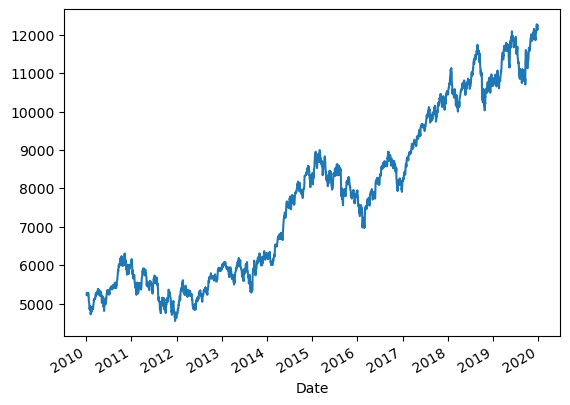

In [3]:
import matplotlib.pyplot as plt
import yfinance as yf

# Get the data of the stock AAPL
data = yf.download('^NSEI','2010-01-01','2019-12-30')

# Plot the close price of the AAPL
data.Close.plot()
plt.show()

In [3]:
data[:5]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0
2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0
2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0


In [4]:
date_split = '2016-06-15'
train = data[:date_split]
test = data[date_split:]
len(train), len(test)

(1576, 866)

In [5]:
def plot_train_test(train, test, date_split):


  data = [
        Candlestick(x=train.index, open=train['Open'], high=train['High'], low=train['Low'], close=train['Close'], name='train'),
        Candlestick(x=test.index, open=test['Open'], high=test['High'], low=test['Low'], close=test['Close'], name='test')
    ]
  layout = {
         'shapes': [
             {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
  figure = Figure(data=data, layout=layout)
  iplot(figure)

In [11]:
plot_train_test(train, test, date_split)

In [6]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

In [7]:
env = Environment1(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    print(env.step(pact))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 45.69970703125], 0, False)
([3.89990234375, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 45.69970703125, 3.89990234375], 0, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [10]:
# DQN

def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards

In [11]:
Q, total_losses, total_rewards = train_dqn(Environment1(train))

C:\Users\hp\AppData\Local\Temp\ipykernel_2436\536579512.py:74: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

C:\Users\hp\AppData\Local\Temp\ipykernel_2436\536579512.py:82: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



5	0.0999999999999992	7875	-240.2	406191.6251595855	76.72507381439209
10	0.0999999999999992	15750	-238.0	4687.321619556844	77.96600317955017
15	0.0999999999999992	23625	-212.4	10974.497651301324	85.9993588924408
20	0.0999999999999992	31500	-29.2	170.99342286637983	86.78205490112305
25	0.0999999999999992	39375	-5.4	38.73217993958569	95.08513951301575
30	0.0999999999999992	47250	-13.0	20.901486891982795	95.37541723251343
35	0.0999999999999992	55125	-7.2	41.49225913549354	100.40933394432068
40	0.0999999999999992	63000	-10.0	17.171716280800034	102.77020168304443
45	0.0999999999999992	70875	-7.6	18.36702784696093	104.04584741592407
50	0.0999999999999992	78750	-6.8	19.4032960235853	110.18954753875732


In [12]:
def plot_loss_reward(total_losses, total_rewards):

    figure = tools.make_subplots(rows=1, cols=2, subplot_titles=('loss', 'reward'), print_grid=False)
    figure.append_trace(Scatter(y=total_losses, mode='lines', line=dict(color='skyblue')), 1, 1)
    figure.append_trace(Scatter(y=total_rewards, mode='lines', line=dict(color='orange')), 1, 2)
    figure['layout']['xaxis1'].update(title='epoch')
    figure['layout']['xaxis2'].update(title='epoch')
    figure['layout'].update(height=400, width=900, showlegend=False)
    iplot(figure)

In [13]:
import os

if not os.path.exists("images"):
    os.mkdir("images")

In [14]:
plot_loss_reward(total_losses, total_rewards)

c:\Users\hp\anaconda3\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [20]:
def plot_train_test_by_q(train_env, test_env, Q, algorithm_name):
    
    # train
    pobs = train_env.reset()
    train_acts = []
    train_rewards = []

    for _ in range(len(train_env.data)-1):
        
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        train_acts.append(pact)
            
        obs, reward, done = train_env.step(pact)
        train_rewards.append(reward)

        pobs = obs
        
    train_profits = train_env.profits
    
    # test
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    for _ in range(len(test_env.data)-1):
    
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        test_acts.append(pact)
            
        obs, reward, done = test_env.step(pact)
        test_rewards.append(reward)

        pobs = obs
        
    test_profits = test_env.profits
    
    # plot
    train_copy = train_env.data.copy()
    test_copy = test_env.data.copy()
    train_copy['act'] = train_acts + [np.nan]
    train_copy['reward'] = train_rewards + [np.nan]
    test_copy['act'] = test_acts + [np.nan]
    test_copy['reward'] = test_rewards + [np.nan]
    train0 = train_copy[train_copy['act'] == 0]
    train1 = train_copy[train_copy['act'] == 1]
    train2 = train_copy[train_copy['act'] == 2]
    test0 = test_copy[test_copy['act'] == 0]
    test1 = test_copy[test_copy['act'] == 1]
    test2 = test_copy[test_copy['act'] == 2]
    act_color0, act_color1, act_color2 = 'gray', 'cyan', 'magenta'

    data = [
        Candlestick(x=train0.index, open=train0['Open'], high=train0['High'], low=train0['Low'], close=train0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=train1.index, open=train1['Open'], high=train1['High'], low=train1['Low'], close=train1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=train2.index, open=train2['Open'], high=train2['High'], low=train2['Low'], close=train2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2))),
        Candlestick(x=test0.index, open=test0['Open'], high=test0['High'], low=test0['Low'], close=test0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=test1.index, open=test1['Open'], high=test1['High'], low=test1['Low'], close=test1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=test2.index, open=test2['Open'], high=test2['High'], low=test2['Low'], close=test2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2)))
    ]
    title = '{}: train s-reward {}, profits {}, test s-reward {}, profits {}'.format(
        algorithm_name,
        int(sum(train_rewards)),
        int(train_profits),
        int(sum(test_rewards)),
        int(test_profits)
    )
    layout = {
        'title': title,
        'showlegend': False,
         'shapes': [
             {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data, layout=layout)
    iplot(figure)

In [25]:
plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'DQN')


In [21]:
# Double DQN

def train_ddqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards

In [22]:
Q, total_losses, total_rewards = train_ddqn(Environment1(train))

C:\Users\hp\AppData\Local\Temp\ipykernel_2436\2971146126.py:74: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

C:\Users\hp\AppData\Local\Temp\ipykernel_2436\2971146126.py:82: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



5	0.0999999999999992	7875	-236.0	13306.525434231758	45.741262912750244
10	0.0999999999999992	15750	-106.0	805.4857129871846	47.73092699050903
15	0.0999999999999992	23625	-41.6	177.7533105504699	48.596760749816895
20	0.0999999999999992	31500	29.8	42.177490551956	53.0513060092926
25	0.0999999999999992	39375	20.0	13.102032100688666	51.16379189491272
30	0.0999999999999992	47250	5.4	11.605832462146646	49.17093348503113
35	0.0999999999999992	55125	18.2	9.135839504604519	49.072601079940796
40	0.0999999999999992	63000	-3.4	3.0224353676330793	45.71151518821716
45	0.0999999999999992	70875	12.0	6.112641486062057	46.947171449661255
50	0.0999999999999992	78750	28.0	3.565480156344711	44.93043375015259


In [24]:
plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'Double DQN')

In [26]:
plot_loss_reward(total_losses, total_rewards)

c:\Users\hp\anaconda3\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [27]:
# Dueling Double DQN

def train_dddqn(env):

    """ <<< Double DQN -> Dueling Double DQN
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()
    === """
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    """ >>> """

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards

In [28]:
Q, total_losses, total_rewards = train_dddqn(Environment1(train))

C:\Users\hp\AppData\Local\Temp\ipykernel_2436\3141201869.py:105: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

C:\Users\hp\AppData\Local\Temp\ipykernel_2436\3141201869.py:113: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



5	0.0999999999999992	7875	-148.8	24203.6488206625	80.45482015609741
10	0.0999999999999992	15750	-75.0	654.4829623296857	81.10054445266724
15	0.0999999999999992	23625	-19.6	73.51744644343853	81.59746170043945
20	0.0999999999999992	31500	28.6	23.096447247173636	85.92042565345764
25	0.0999999999999992	39375	8.2	434.43896987694313	92.10846495628357
30	0.0999999999999992	47250	26.2	9.252705664210954	85.98377561569214
35	0.0999999999999992	55125	-5.2	5.761759638920194	83.7321207523346
40	0.0999999999999992	63000	61.0	9.274112798689748	87.70594549179077
45	0.0999999999999992	70875	63.0	7.68302782568353	85.01573419570923
50	0.0999999999999992	78750	122.0	7.986817918455927	170.4836585521698


In [29]:
plot_loss_reward(total_losses, total_rewards)

In [30]:
plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'Dueling Double DQN')

In [1]:
import chainer
import chainer.functions as F
import chainer.links as L
import copy
import numpy as np
import random
import time
from collections import deque, namedtuple

# Define a namedtuple to store experience with priority
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done', 'priority'))

# Define the Q-Network
class Q_Network(chainer.Chain):
    def __init__(self, input_size, hidden_size, output_size):
        super(Q_Network, self).__init__(
            fc1=L.Linear(input_size, hidden_size),
            fc2=L.Linear(hidden_size, hidden_size),
            fc3=L.Linear(hidden_size, output_size)
        )

    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        y = self.fc3(h)
        return y

# ...

def train_per_ddqn(env):

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    alpha = 0.6  # Prioritization parameter
    beta = 0.4   # Importance-sampling weight parameter
    beta_increment_per_sampling = 0.001

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory with priority
            max_priority = np.max([exp.priority for exp in memory]) if memory else 1.0
            priority = (reward + gamma * np.max(Q(np.array(obs, dtype=np.float32).reshape(1, -1)).data) - Q(np.array(pobs, dtype=np.float32).reshape(1, -1)).data[0][pact])**alpha
            experience = Experience(pobs, pact, reward, obs, done, priority)
            memory.append(experience)
            total_reward += reward

            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) >= memory_size:
                if total_step % train_freq == 0:
                    priorities = np.array([exp.priority for exp in memory])
                    sampling_probabilities = priorities / np.sum(priorities)
                    indices = np.random.choice(len(memory), size=batch_size, p=sampling_probabilities)
                    experiences = [memory[idx] for idx in indices]

                    states = np.array([exp.state for exp in experiences], dtype=np.float32)
                    actions = np.array([exp.action for exp in experiences], dtype=np.int32)
                    rewards = np.array([exp.reward for exp in experiences], dtype=np.float32)
                    next_states = np.array([exp.next_state for exp in experiences], dtype=np.float32)
                    dones = np.array([exp.done for exp in experiences], dtype=np.bool)

                    state_tensor = chainer.Variable(states)
                    action_tensor = chainer.Variable(actions)
                    reward_tensor = chainer.Variable(rewards)
                    next_state_tensor = chainer.Variable(next_states)
                    done_tensor = chainer.Variable(dones)

                    q_values = Q(state_tensor)
                    next_q_values = Q_ast(next_state_tensor)
                    next_max_q_values = F.max(next_q_values, axis=1)
                    target_q_values = reward_tensor + gamma * next_max_q_values * (1 - done_tensor)
                    td_errors = q_values.data[np.arange(batch_size), actions] - target_q_values.data
                    priorities[indices] = np.abs(td_errors) + 1e-6
                    total_loss += np.mean(td_errors ** 2)

                    loss = F.mean_squared_error(q_values, target_q_values)
                    optimizer.update(loss)

                    for i, idx in enumerate(indices):
                        memory[idx] = memory[idx]._replace(priority=priorities[i])

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

                if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                    epsilon -= epsilon_decrease

                beta = np.min([1.0, beta + beta_increment_per_sampling])

            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = np.mean(total_rewards[-show_log_freq:])
            log_loss = np.mean(total_losses[-show_log_freq:])
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()

    return Q, total_losses, total_rewards

# ...




In [8]:
Q, total_losses, total_rewards = train_per_ddqn(Environment1(train))

C:\Users\hp\AppData\Local\Temp\ipykernel_28804\1307619918.py:81: RuntimeWarning:

invalid value encountered in double_scalars



ValueError: probabilities contain NaN